In [1]:
import geopandas as gpd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import shapely.wkt
import shapely.geometry
import pandas as pd
import shapely.geometry.multipolygon as sh

In [2]:
## First, I try to create a bouadary of THialand for acquiring data##
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
min_lon = thailandmap.unary_union.bounds[0]
max_lon = thailandmap.unary_union.bounds[2]
max_lat = thailandmap.unary_union.bounds[1]
min_lat = thailandmap.unary_union.bounds[3]

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data variables:
    index     (lat, lon) float64 ...
    SI_Solar  (lat, lon) float64 ...
    SI_Wind   (lat, lon) float64 ...


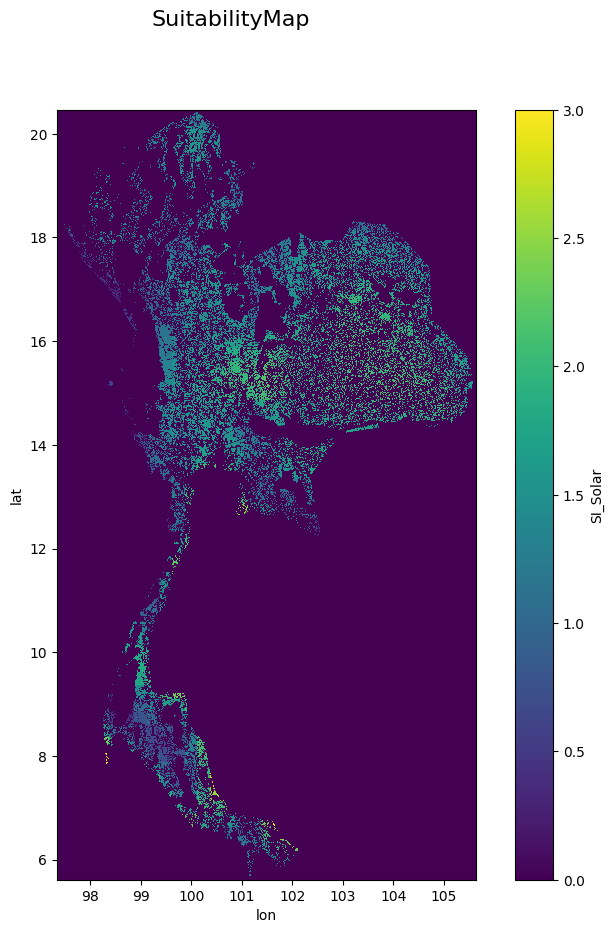

In [3]:
xr_landuse_suitability_index = xr.open_dataset('Output\\xr_SI_resourcepotential.nc')
print(xr_landuse_suitability_index.data_vars)
fig, ax = plt.subplots(figsize=(10,10))
title = 'SuitabilityMap'
type = 'SI_Solar' 
fig.suptitle(str(title), fontsize=16)
thailandmap.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0,alpha = 0.1)
xr_landuse_suitability_index[type].plot(ax = ax,zorder = 1)

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6763: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:6764: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


(array([[0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [3.2080e+03, 1.4429e+04, 4.6755e+04, ..., 8.8590e+03, 2.7000e+01,
         1.2980e+03],
        [3.2080e+03, 1.4429e+04, 4.6755e+04, ..., 8.8590e+03, 2.7000e+01,
         1.2980e+03],
        [3.2080e+03, 1.4429e+04, 4.6755e+04, ..., 8.8590e+03, 2.7000e+01,
         1.2980e+03]]),
 array([0.06437315, 0.30900872, 0.55364429, 0.79827986, 1.04291543,
        1.287551  , 1.53218658, 1.77682215, 2.02145772, 2.26609329,
        2.51072886, 2.75536443, 3.        ]),
 <a list of 2985 BarContainer objects>)

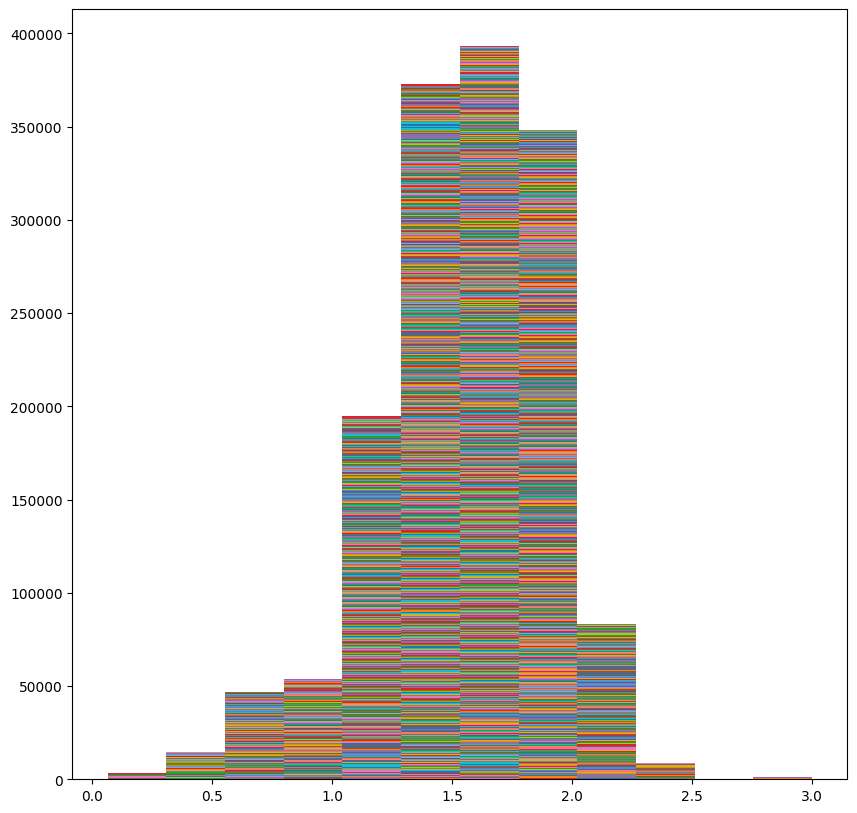

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
plt.hist(xr_landuse_suitability_index[type].where(xr_landuse_suitability_index[type]>0),histtype ='barstacked',bins=12)

In [5]:
print(xr_landuse_suitability_index['SI_Solar'].where(xr_landuse_suitability_index['SI_Solar']==1).count() * 0.09)

<xarray.DataArray 'SI_Solar' ()>
array(0.)


In [6]:
province = "Kalasin"
province_th = thailandmap.loc[thailandmap['ADM1_EN'] == province]
min_lon = province_th.unary_union.bounds[0]
max_lon = province_th.unary_union.bounds[2]
max_lat = province_th.unary_union.bounds[1]
min_lat = province_th.unary_union.bounds[3]

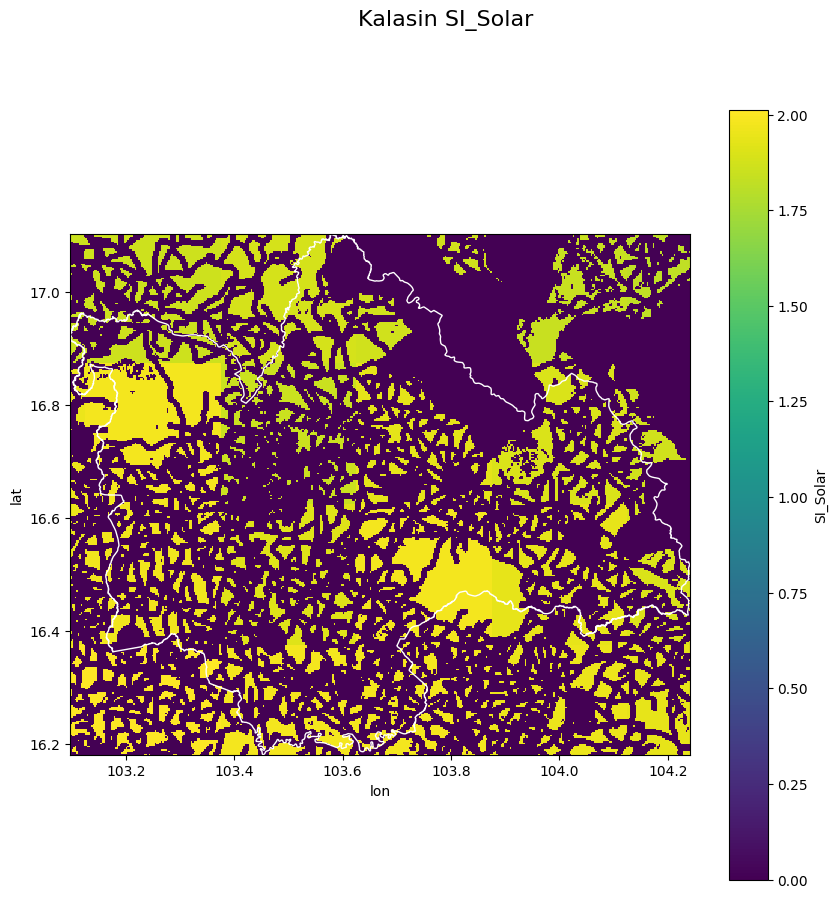

In [7]:
xr_landuse_suitability_index_area = xr_landuse_suitability_index.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(province +' '+ str(type), fontsize=16)
province_th.plot(ax = ax, color='none', edgecolor = 'white', zorder = 1)
xr_landuse_suitability_index_area[type].plot(ax = ax,zorder = 0)